# Imports

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split , cross_val_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical


# Data analysis

In [79]:
data = pd.read_csv('mushroom_data.csv')
data.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [80]:
# import pandas as pd
# from ydata_profiling import ProfileReport

# df = pd.read_csv('mushroom_data.csv')
# profile = ProfileReport(df, title="Profiling Report")
# profile

In [81]:
data.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
count,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000
mean,567.257204,4.000315,2.142056,7.329509,0.759110,1051.081299,8.418062,0.952163,0.549181
std,359.883763,2.160505,2.228821,3.200266,0.650969,782.056076,3.262078,0.305594,0.497580
min,0.000000,0.000000,0.000000,0.000000,0.000426,0.000000,0.000000,0.027372,0.000000
25%,289.000000,2.000000,0.000000,5.000000,0.270997,421.000000,6.000000,0.888450,0.000000
50%,525.000000,5.000000,1.000000,8.000000,0.593295,923.000000,11.000000,0.943195,1.000000
75%,781.000000,6.000000,4.000000,10.000000,1.054858,1523.000000,11.000000,0.943195,1.000000
max,1891.000000,6.000000,6.000000,11.000000,3.835320,3569.000000,12.000000,1.804273,1.000000


Unique values counting

In [82]:
unique_seasons = data['cap-diameter'].unique()
print(unique_seasons.shape)

unique_seasons = data['stem-height'].unique()
print(unique_seasons.shape)

unique_seasons = data['stem-width'].unique()
print(unique_seasons.shape)

(1847,)
(1455,)
(3510,)


values in season table seems odd

In [83]:
unique_seasons = data['season'].unique()
print(unique_seasons)

data['season'] = data['season'].round(2)

unique_seasons = data['season'].unique()
print(unique_seasons)

mapping = {1.8: 1, 0.94: 2, 0.89: 3, 0.03: 4}
data['season'] = data['season'].map(mapping)

unique_seasons = data['season'].unique()
print(unique_seasons)


[1.80427271 0.94319455 0.88845029 0.02737213]
[1.8  0.94 0.89 0.03]
[1 2 3 4]


to make data easier to read i decided to rename column "class" to "edible". Because 1 means that mushroom is not edible i  inverted the values.

In [84]:
data.rename(columns={'class': 'edible'}, inplace=True)

data['edible'] = data['edible'].apply(lambda x: 1 if x == 0 else 0)
data.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,edible
0,1372,2,2,10,3.807467,1545,11,1,0
1,1461,2,2,10,3.807467,1557,11,1,0
2,1371,2,2,10,3.612496,1566,11,1,0
3,1261,6,2,10,3.787572,1566,11,1,0
4,1305,6,2,10,3.711971,1464,11,2,0


# Check for missing, wrong or duplicated data

In [85]:
def count_nulls(dataframe):
    return dataframe.isnull().sum()

print(count_nulls(data))

cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
edible             0
dtype: int64


In [86]:
zero_counts = (data == 0).sum()
print(zero_counts)

cap-diameter           1
cap-shape           5273
gill-attachment    19405
gill-color           953
stem-height            0
stem-width          1059
stem-color           173
season                 0
edible             29675
dtype: int64


In [87]:
data = data[(data['cap-diameter'] != 0) & (data['stem-width'] != 0)]
zero_counts = (data == 0).sum()
print(zero_counts)

cap-diameter           0
cap-shape           5273
gill-attachment    19051
gill-color           953
stem-height            0
stem-width             0
stem-color           173
season                 0
edible             28615
dtype: int64


i will assume that 0 in cap-diameter and stem-width is a mistake

Duplicated data

In [88]:
duplicates = data[data.duplicated()]

num_duplicates = len(duplicates)
print("number of duplicates :", num_duplicates)

duplicate_classes = duplicates['edible'].value_counts()
print("duplicates edibility:")
print(duplicate_classes)

data = data.drop_duplicates()


number of duplicates : 3
duplicates edibility:
edible
0    3
Name: count, dtype: int64


In [89]:
data.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,edible
count,52972.000000,52972.000000,52972.000000,52972.000000,52972.000000,52972.000000,52972.000000,52972.000000,52972.000000
mean,571.865816,4.020275,2.145058,7.382598,0.734019,1072.165238,8.546421,2.378634,0.459866
std,361.763994,2.177274,2.242005,3.165055,0.632573,775.426613,3.164345,0.681428,0.498391
min,1.000000,0.000000,0.000000,0.000000,0.000426,1.000000,0.000000,1.000000,0.000000
25%,291.000000,2.000000,0.000000,5.000000,0.266167,454.000000,6.000000,2.000000,0.000000
50%,535.000000,5.000000,1.000000,8.000000,0.580507,946.000000,11.000000,2.000000,0.000000
75%,787.000000,6.000000,4.000000,10.000000,1.023026,1538.000000,11.000000,3.000000,1.000000
max,1891.000000,6.000000,6.000000,11.000000,3.835320,3569.000000,12.000000,4.000000,1.000000


# Now data is complete and cleaned

Spilt the training and test data


In [90]:

X = data.drop('edible', axis=1)
Y = data['edible']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=42)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, Y, train_size=0.1,test_size=0.05, stratify=Y, random_state=42)



Now check the balance between edible and non edible mushrooms in datasets

In [91]:
datasets = [
    {'name': 'all_data', 'Y': Y},
    {'name': 'train_data', 'Y': y_train},
    {'name': 'test_data', 'Y': y_test},
]

def print_edible_balance(dataset,name,Y_set):
    value_counts = Y_set.value_counts()
    total = len(Y_set)
    balance = value_counts / total * 100
    print(f"{name}:")
    print(value_counts)
    print(f"Edible % :\n{balance}\n")
        
for dataset in datasets:
    name = dataset['name']
    Y_set = dataset['Y']
    print_edible_balance(dataset,name,Y_set)

all_data:
edible
0    28612
1    24360
Name: count, dtype: int64
Edible % :
edible
0    54.013441
1    45.986559
Name: count, dtype: float64

train_data:
edible
0    22889
1    19488
Name: count, dtype: int64
Edible % :
edible
0    54.01279
1    45.98721
Name: count, dtype: float64

test_data:
edible
0    5723
1    4872
Name: count, dtype: int64
Edible % :
edible
0    54.016045
1    45.983955
Name: count, dtype: float64



Data sets seem fairly balanced 

# Corelations between data

histograms

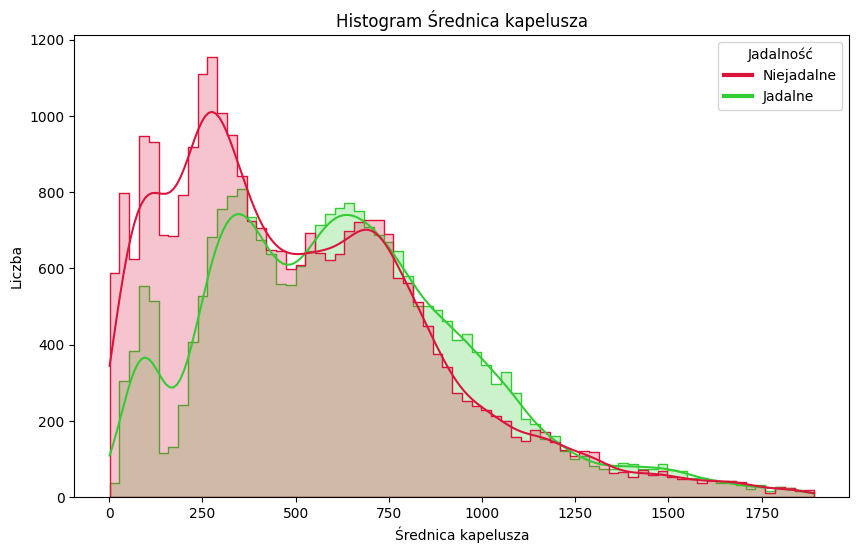

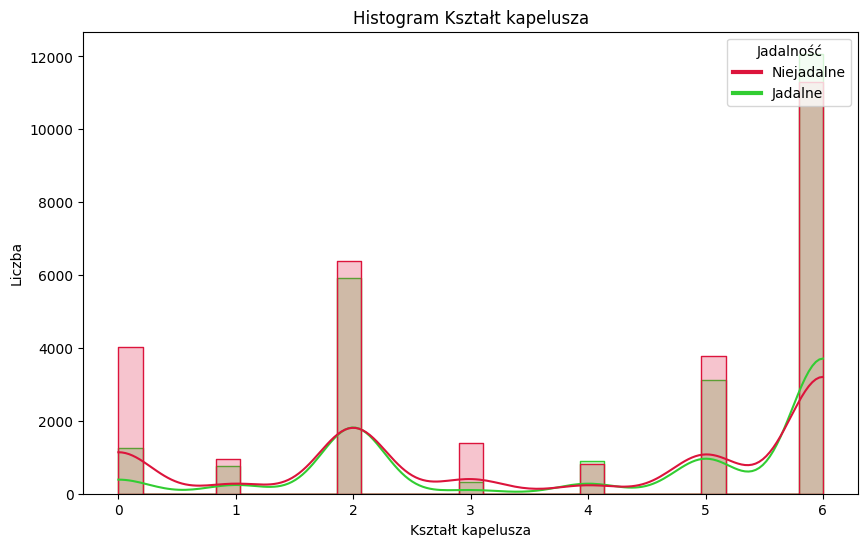

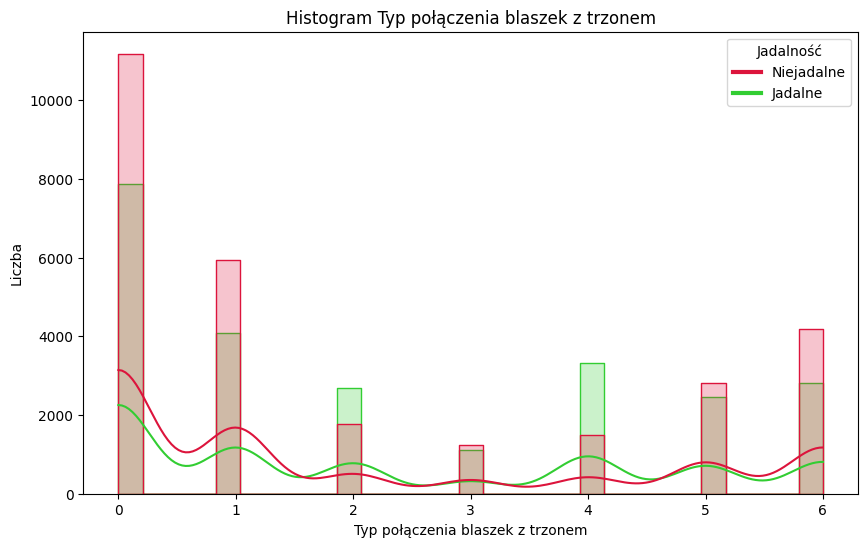

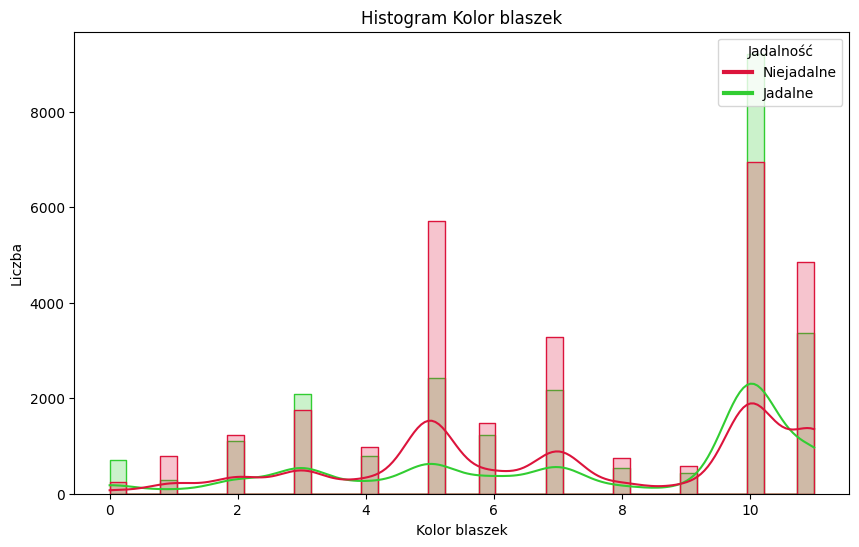

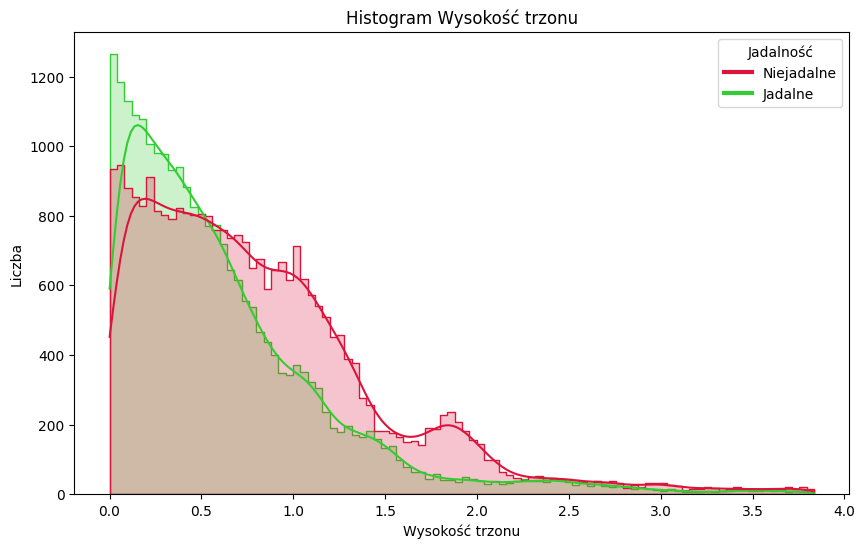

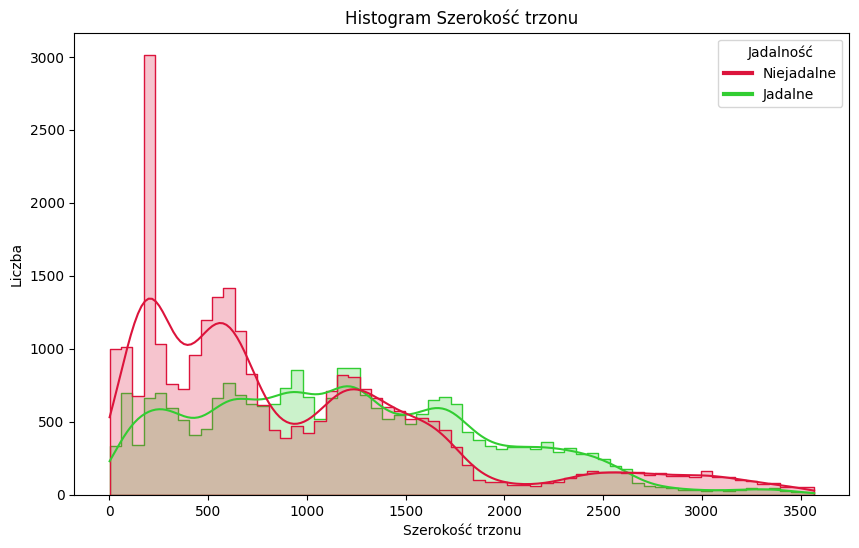

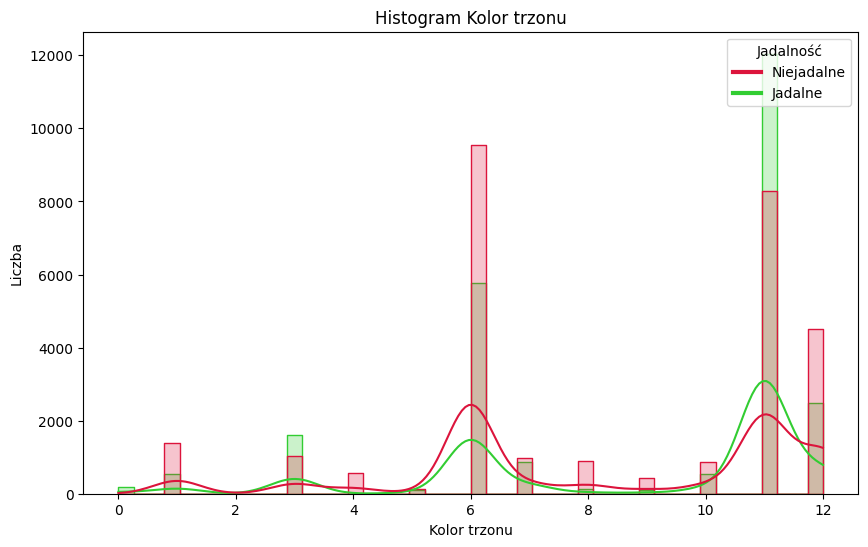

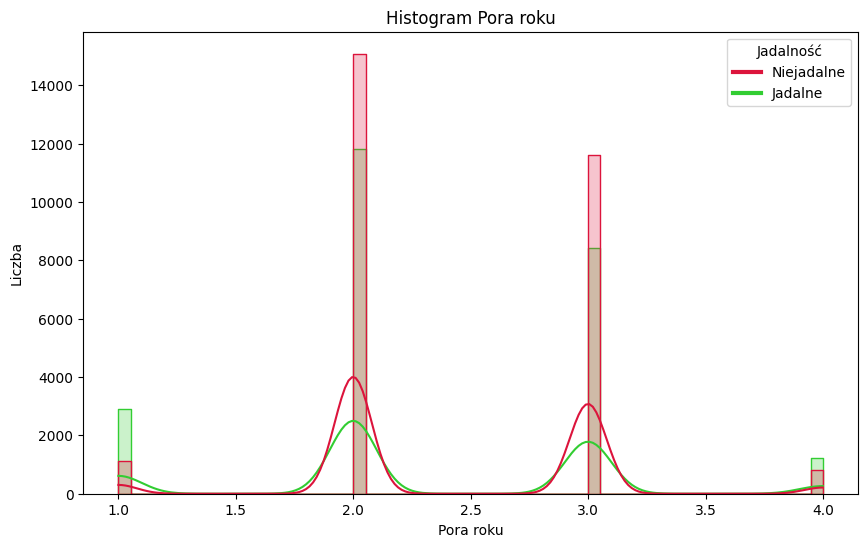

In [92]:
features = ['cap-diameter', 'cap-shape', 'gill-attachment', 'gill-color', 'stem-height', 'stem-width', 'stem-color', 'season']
features_polish = ['Średnica kapelusza', 'Kształt kapelusza', 'Typ połączenia blaszek z trzonem', 'Kolor blaszek', 'Wysokość trzonu', 'Szerokość trzonu', 'Kolor trzonu', 'Pora roku']

colors = {0: 'crimson', 1: '#32CD32'}

for feature, feature_polish in zip(features, features_polish):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=feature, hue='edible', kde=True, element='step', palette=colors)
    plt.title(f'Histogram {feature_polish}')
    plt.xlabel(feature_polish)
    plt.ylabel('Liczba')
    legend_labels = ['Niejadalne', 'Jadalne']
    handles = [plt.Line2D([0, 0], [0, 0], color=color, linewidth=3) for _, color in colors.items()]
    plt.legend(handles, legend_labels, title='Jadalność', loc='upper right')
    plt.show()



correlation matrix

In [93]:
from sklearn.preprocessing import MinMaxScaler

data_normalized = data.copy()
scaler = MinMaxScaler()
data_normalized[features] = scaler.fit_transform(data_normalized[features])

print(data_normalized.describe())

       cap-diameter     cap-shape  gill-attachment    gill-color  \
count  52972.000000  52972.000000     52972.000000  52972.000000   
mean       0.302045      0.670046         0.357510      0.671145   
std        0.191410      0.362879         0.373668      0.287732   
min        0.000000      0.000000         0.000000      0.000000   
25%        0.153439      0.333333         0.000000      0.454545   
50%        0.282540      0.833333         0.166667      0.727273   
75%        0.415873      1.000000         0.666667      0.909091   
max        1.000000      1.000000         1.000000      1.000000   

        stem-height    stem-width    stem-color        season        edible  
count  52972.000000  52972.000000  52972.000000  52972.000000  52972.000000  
mean       0.191294      0.300214      0.712202      0.459545      0.459866  
std        0.164952      0.217328      0.263695      0.227143      0.498391  
min        0.000000      0.000000      0.000000      0.000000      0.000000

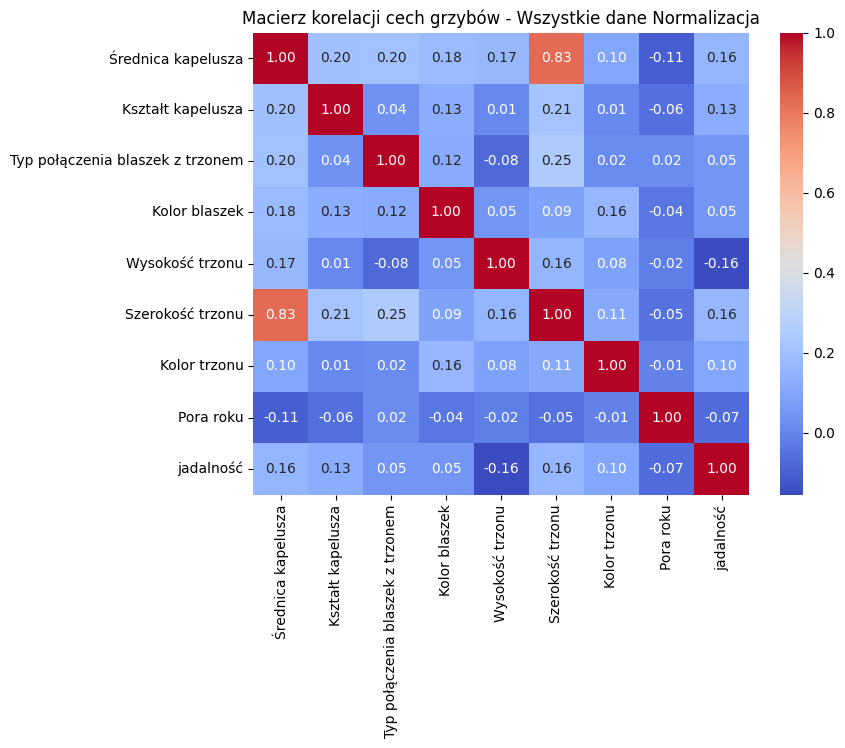

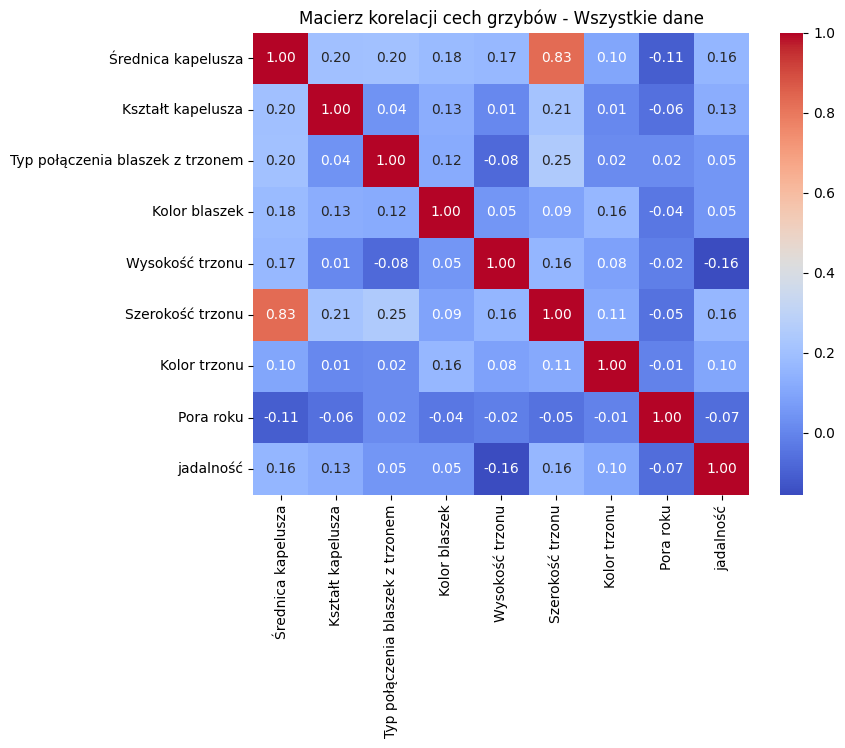

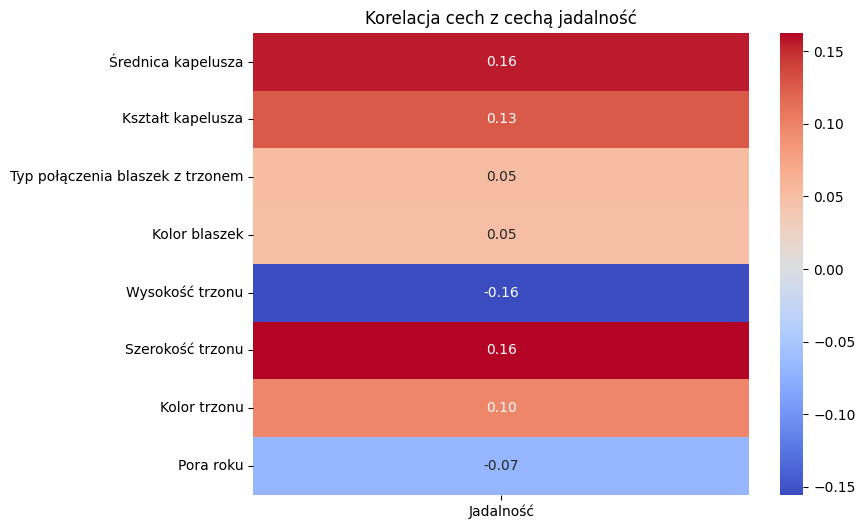

In [94]:
all_features = ['cap-diameter', 'cap-shape', 'gill-attachment', 'gill-color', 'stem-height', 'stem-width', 'stem-color', 'season','edible']
all_features_polish = ['Średnica kapelusza', 'Kształt kapelusza', 'Typ połączenia blaszek z trzonem', 'Kolor blaszek', 'Wysokość trzonu', 'Szerokość trzonu', 'Kolor trzonu', 'Pora roku','jadalność']



def plot_corr_matrix(data_set, title):
    corr_matrix = data_set.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=all_features_polish, yticklabels=all_features_polish)
    plt.title(title)
    plt.show()
    
def plot_corr_with_edible(data_set, all_features, all_features_polish):
    corr_matrix = data_set.corr()
    edible_corr = corr_matrix[['edible']].drop(index='edible')
    mask = ~edible_corr.index.isin(all_features[:-1])
    edible_corr[mask] = None
    plt.figure(figsize=(8, 6))
    sns.heatmap(edible_corr, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=['Jadalność'], yticklabels=all_features_polish[:-1])
    plt.title('Korelacja cech z cechą jadalność')
    plt.show()

plot_corr_matrix(data_normalized[all_features], 'Macierz korelacji cech grzybów - Wszystkie dane Normalizacja')
plot_corr_matrix(data[all_features], 'Macierz korelacji cech grzybów - Wszystkie dane')

plot_corr_with_edible(data_normalized[all_features], all_features, all_features_polish)


Amount of edible and non edible mushrooms in dataset

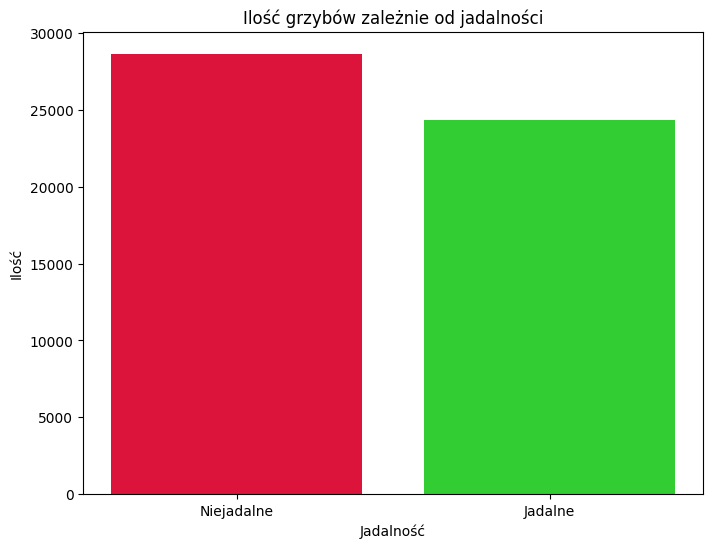

In [95]:
colors = {0: 'crimson', 1: '#32CD32'}

edible_counts = data['edible'].value_counts()

# Tworzenie wykresu
plt.figure(figsize=(8, 6))
plt.bar(edible_counts.index.astype(str), edible_counts.values, color=[colors[x] for x in edible_counts.index])
plt.xlabel('Jadalność')
plt.ylabel('Ilość')
plt.title('Ilość grzybów zależnie od jadalności')
plt.xticks([0, 1], ['Niejadalne', 'Jadalne'])
plt.show()

box plots

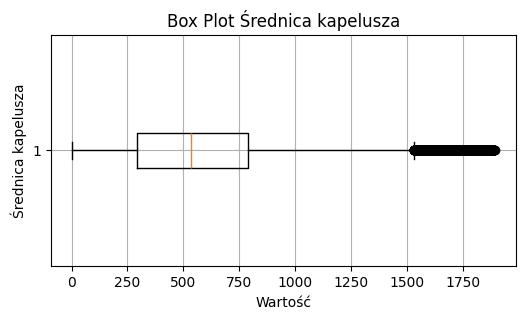

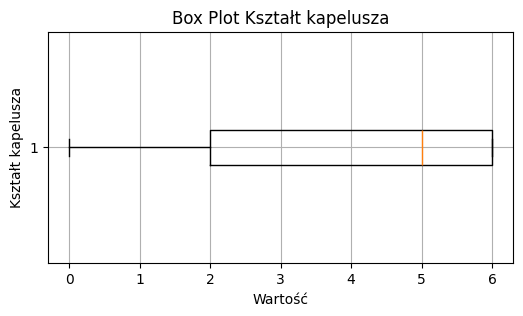

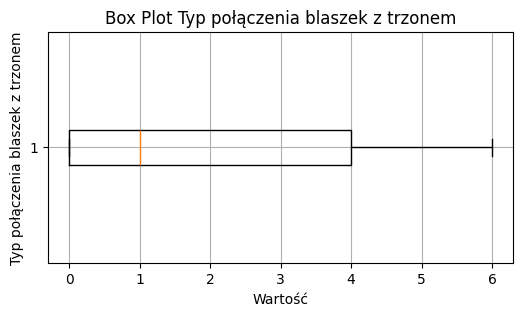

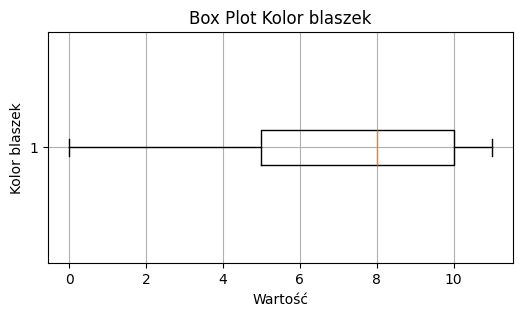

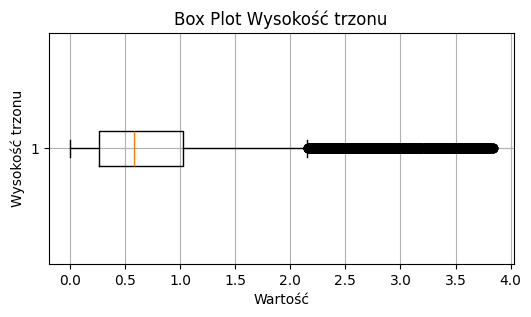

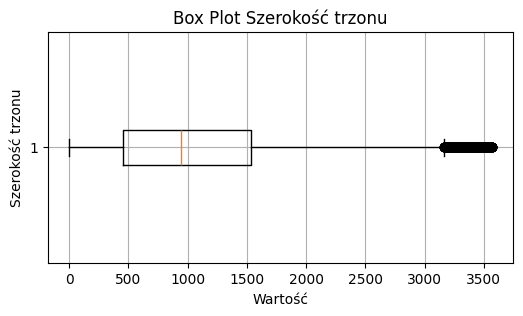

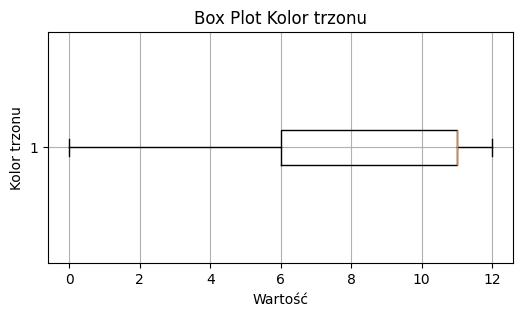

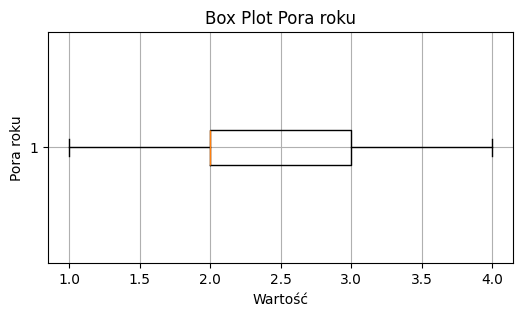

In [96]:
for feature, feature_polish in zip(features, features_polish):
    plt.figure(figsize=(6, 3))
    plt.boxplot(data[feature], vert=False)
    plt.title(f'Box Plot {feature_polish}')
    plt.xlabel('Wartość')
    plt.ylabel(feature_polish)
    plt.grid(True)
    plt.show()

In [97]:
def remove_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

data_no_outliers = data.copy()
data_no_outliers = remove_outliers(data_no_outliers, features)

X_no_outliers = data_no_outliers.drop('edible', axis=1)
Y_no_outliers = data_no_outliers['edible']

print("Orginal data size :", data.shape)
print("No outliers data szie :", data_no_outliers.shape)
print()

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X_no_outliers, Y_no_outliers, test_size=0.2, random_state=42)
print_edible_balance(X_no_outliers,"Data with no outliers",Y_no_outliers)

Orginal data size : (52972, 9)
No outliers data szie : (49615, 9)

Data with no outliers:
edible
0    26543
1    23072
Name: count, dtype: int64
Edible % :
edible
0    53.497934
1    46.502066
Name: count, dtype: float64



SVM Model

In [98]:
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto'] 
# }

# grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5)

# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)

# best_svm_model = grid_search.best_estimator_
# y_pred = best_svm_model.predict(X_test)

# svm_accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {svm_accuracy:.2f}')

# print('\nClassification Report:')
# print(classification_report(y_test, y_pred))

# i gave up after 20h of training

Neural network

In [99]:
def create_neural_network():
    model = Sequential()
    model.add(Dense(units=8, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


neural_net = KerasClassifier(build_fn=create_neural_network, epochs=500, batch_size=64)
#history = neural_net.fit(X_train, y_train, epochs=500, batch_size=32)



In [100]:
# y_pred = neural_net.predict(X_test)
# net_accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy on full test set: {net_accuracy:.2f}')

In [101]:
def find_best_parameters(model, parameters, X, y, cv=10, verbose=1, n_jobs=-1):
    grid_object = GridSearchCV(model, parameters, scoring=make_scorer(accuracy_score), cv=cv, verbose=verbose, n_jobs=n_jobs)
    grid_object = grid_object.fit(X, y)
    return grid_object.best_estimator_

Random Forrest

In [102]:
param_grid_forrest = {
    'n_estimators': [10, 50, 200],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
random_forest = RandomForestClassifier()
random_forest = find_best_parameters(random_forest, param_grid_forrest, X_train, y_train)


Fitting 10 folds for each of 162 candidates, totalling 1620 fits


In [103]:
y_pred = random_forest.predict(X_test)

forrest_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on full test set: {forrest_accuracy:.2f}')

print('\nClassification Report for full test set:')
print(classification_report(y_test, y_pred))

Accuracy on full test set: 0.99

Classification Report for full test set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5723
           1       0.99      0.99      0.99      4872

    accuracy                           0.99     10595
   macro avg       0.99      0.99      0.99     10595
weighted avg       0.99      0.99      0.99     10595



Logistic Regression

In [104]:
param_grid_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
}

logistic_regression = LogisticRegression()
logistic_regression = find_best_parameters(logistic_regression, param_grid_reg, X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [105]:
y_pred = logistic_regression.predict(X_test)

log_reg_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on full test set: {log_reg_accuracy:.2f}')

print('\nClassification Report for full test set:')
print(classification_report(y_test, y_pred))

Accuracy on full test set: 0.63

Classification Report for full test set:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      5723
           1       0.61      0.54      0.57      4872

    accuracy                           0.63     10595
   macro avg       0.62      0.62      0.62     10595
weighted avg       0.63      0.63      0.62     10595



Naive bayses

In [120]:
param_grid_gnb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
}
gnb = GaussianNB()
gnb = find_best_parameters(gnb, param_grid_gnb, X_train, y_train)


Fitting 10 folds for each of 6 candidates, totalling 60 fits


In [121]:
y_pred = gnb.predict(X_test)

gnb_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on full test set: {gnb_accuracy:.2f}')

print('\nClassification Report for full test set:')
print(classification_report(y_test, y_pred))

Accuracy on full test set: 0.64

Classification Report for full test set:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67      5723
           1       0.61      0.62      0.61      4872

    accuracy                           0.64     10595
   macro avg       0.64      0.64      0.64     10595
weighted avg       0.64      0.64      0.64     10595



In [122]:
random_forest_scores = cross_val_score(random_forest, X_train, y_train, scoring='accuracy', cv=5)
log_reg_scores = cross_val_score(logistic_regression, X_train, y_train, scoring='accuracy', cv=5)
gnb_scores = cross_val_score(gnb, X_train, y_train, scoring='accuracy', cv=5)
neural_net_scores = cross_val_score(neural_net, X_train, y_train, scoring='accuracy', cv=5)
#svc was excluded from final comparison as i was unable to train it on full dataset

Epoch 1/500


c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5476 - loss: 4.3927
Epoch 2/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5678 - loss: 0.7483
Epoch 3/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5769 - loss: 0.7322
Epoch 4/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5808 - loss: 0.7147
Epoch 5/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5828 - loss: 0.6959
Epoch 6/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5810 - loss: 0.6822
Epoch 7/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5777 - loss: 0.7064
Epoch 8/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5940 - loss: 0.6641
Epoch 9/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5849 - loss: 0.6820
Epoch 10/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6035 - loss: 0.6447
Epoch 11/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6013 - loss: 0.6432
Epoch 12/500
1060/1060 ━━━━━━━━

c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5183 - loss: 4.1881
Epoch 2/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5568 - loss: 0.8013
Epoch 3/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5587 - loss: 0.7747
Epoch 4/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5758 - loss: 0.7143
Epoch 5/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.5894 - loss: 0.7047
Epoch 6/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - accuracy: 0.6036 - loss: 0.6772
Epoch 7/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5996 - loss: 0.6808
Epoch 8/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6098 - loss: 0.6532
Epoch 9/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.6255 - loss: 0.6304
Epoch 10/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6251 - loss: 0.6210
Epoch 11/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6352 - loss: 0.6102
Epoch 12/500
1060/1060 ━━

c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5566 - loss: 2.0331
Epoch 2/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5970 - loss: 0.6798
Epoch 3/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5997 - loss: 0.6677
Epoch 4/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6107 - loss: 0.6488
Epoch 5/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.6201 - loss: 0.6407
Epoch 6/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6186 - loss: 0.6327
Epoch 7/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6387 - loss: 0.6250
Epoch 8/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6346 - loss: 0.6255
Epoch 9/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6445 - loss: 0.6183
Epoch 10/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6397 - loss: 0.6169
Epoch 11/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6410 - loss: 0.6147
Epoch 12/500
1060/1060 ━━━━━━

c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5563 - loss: 1.3130
Epoch 2/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5858 - loss: 0.7430
Epoch 3/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5928 - loss: 0.7299
Epoch 4/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6058 - loss: 0.7092
Epoch 5/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6096 - loss: 0.6883
Epoch 6/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6184 - loss: 0.6808
Epoch 7/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.6174 - loss: 0.6766
Epoch 8/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6228 - loss: 0.6748
Epoch 9/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6326 - loss: 0.6584
Epoch 10/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.6213 - loss: 0.6725
Epoch 11/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6361 - loss: 0.6529
Epoch 12/500
1060/1060 ━━━━

c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Jacek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5050 - loss: 2.3862
Epoch 2/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5795 - loss: 0.7136
Epoch 3/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5766 - loss: 0.7156
Epoch 4/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5882 - loss: 0.6921
Epoch 5/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5941 - loss: 0.6922
Epoch 6/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6032 - loss: 0.6792
Epoch 7/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6072 - loss: 0.6776
Epoch 8/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6182 - loss: 0.6620
Epoch 9/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6239 - loss: 0.6542
Epoch 10/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6350 - loss: 0.6413
Epoch 11/500
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6373 - loss: 0.6392
Epoch 12/500
1060/1

# Final Results

In [123]:
results = [
    ['Random Forest', np.mean(random_forest_scores)],
    ['Neural Network', np.mean(neural_net_scores)],
    ['Logistic Regression', np.mean(log_reg_scores)],
    ['GaussianNB', np.mean(gnb_scores)],
]

results.sort(key = lambda model: model[1])
results = pd.DataFrame(data=results, columns=['Model', 'Score'])
results

,Model,Score
0,Logistic Regression,0.625740
1,GaussianNB,0.635604
2,Neural Network,0.800340
3,Random Forest,0.989641


C:\Users\Jacek\AppData\Local\Temp\ipykernel_8840\2663270106.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x='Model', y='Score', data=results, palette=colors)


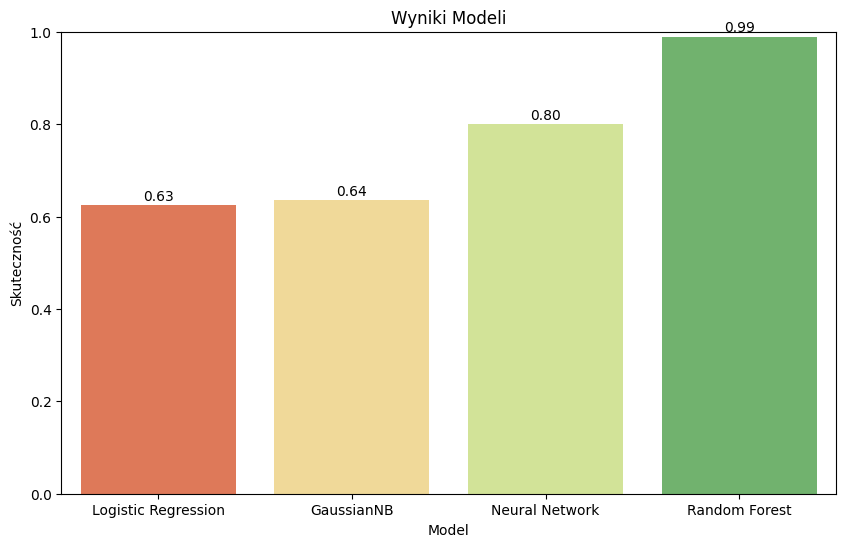

In [124]:
colors = sns.color_palette("RdYlGn", len(results))

plt.figure(figsize=(10, 6))
plot = sns.barplot(x='Model', y='Score', data=results, palette=colors)
plot.set(ylim=(0, 1))
plt.title('Wyniki Modeli')
plt.xlabel('Model')
plt.ylabel('Skuteczność')

for index, row in results.iterrows():
    plot.text(index, row.Score + 0.01, f'{row.Score:.2f}', color='black', ha="center")

plt.show()